In [28]:
from models import vae_HYP, vae_HYP_1, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time

In [29]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                               download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
# print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=256, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)


TypeError: __init__() got an unexpected keyword argument 'train'

In [ ]:
model = vae_HYP.VariationalAutoencoder(latent_dims=4)

In [ ]:
learning_rate = 1e-3

In [ ]:
optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
#optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [ ]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [ ]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 57803.191406
	 partial train loss (single batch): 56220.957031
	 partial train loss (single batch): 54748.554688
	 partial train loss (single batch): 53788.843750
	 partial train loss (single batch): 52694.789062
	 partial train loss (single batch): 51830.125000
	 partial train loss (single batch): 50679.734375
	 partial train loss (single batch): 49943.472656
	 partial train loss (single batch): 49106.308594
	 partial train loss (single batch): 48361.886719
	 partial train loss (single batch): 47623.375000
	 partial train loss (single batch): 46876.019531
	 partial train loss (single batch): 46488.492188
	 partial train loss (single batch): 45738.769531
	 partial train loss (single batch): 44996.660156
	 partial train loss (single batch): 44487.097656
	 partial train loss (single batch): 43933.160156
	 partial train loss (single batch): 43506.136719
	 partial train loss (single batch): 42919.375000
	 partial train loss (single batch): 42367.925781


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000022255D78550>
Traceback (most recent call last):
  File "C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


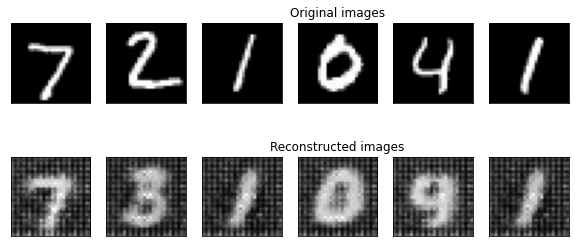

	 partial train loss (single batch): 14937.324219
	 partial train loss (single batch): 15133.092773
	 partial train loss (single batch): 14932.522461
	 partial train loss (single batch): 15044.580078
	 partial train loss (single batch): 14816.563477
	 partial train loss (single batch): 14753.790039
	 partial train loss (single batch): 14884.242188
	 partial train loss (single batch): 14533.741211
	 partial train loss (single batch): 14797.703125
	 partial train loss (single batch): 14552.767578
	 partial train loss (single batch): 14648.447266
	 partial train loss (single batch): 14433.227539
	 partial train loss (single batch): 14406.304688
	 partial train loss (single batch): 14458.000977
	 partial train loss (single batch): 14462.513672
	 partial train loss (single batch): 14316.096680
	 partial train loss (single batch): 14437.027344
	 partial train loss (single batch): 14450.239258
	 partial train loss (single batch): 14404.192383
	 partial train loss (single batch): 14300.919922


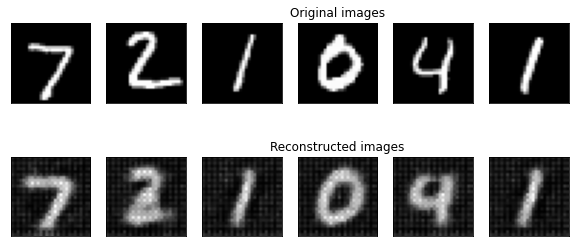

KeyboardInterrupt: 

In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [ ]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)



from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import plotly.express as px

#Davies-Bouldin Index
db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
print(db_index)

#Calinski-Harabasz Index
ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# print(s_coeff)

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:53<00:00, 188.03it/s]


1.1161787759456805
27862.528326684373


In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# print(s_coeff)
fig.show()